# CIFAR-10 Dataset CNN Model achieving 85.97% accuracy with regularization and data augmentation

This notebook is the result of a series of experiments I conducted on the CIFAR-10 dataset to understand hyperparameter tuning of a Convolutional Neural Network.  It explains the model with the final parameters that achieved the highest results. This model secures a 85.97% accuracy on unseen test data.

# CIFAR-10 dataset
The CIFAR-10 dataset contains 60,000 color images of dimension 32 X 32 in 3 channels divided into 10 classes. The training data has 50,000 images and the test data has 10,000. You can read more about the dataset here: https://www.cs.toronto.edu/~kriz/cifar.html 
This is a mulyi-label image classification problem with 10 labels. The data is equally split between the labels.

### Import the required libraries

In [20]:
from tensorflow.keras.datasets import cifar10

import numpy as np
import pandas as pd

import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from PIL import Image

### Load the dataset from the keras library and split into train and test set
This is the easiest way to load the CIFAR-10 dataset. You can also download the files from the link in the introduction, but requires a lot more steps to bring it to a usable state. 

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


### Normalize the train and test data
Converting to float and dividing each instance by 255 so that all the image pixels are between 0 and 1

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

### One Hot Encode the labels

The labels are currently vectors stored as a list with 10 values, all are zero except the correct index for that label will be a 1. 
Example: 
- Airplane --> [1,0,0,0,0,0,0,0,0,0] 
- Automobile --> [0,1,0,0,0,0,0,0,0,0]
- Bird --> [0,0,1,0,0,0,0,0,0,0]

We want to split them into separate columns by one hot encoding them

In [6]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### Splitting the train set for a validation set

We will further split the training set to create a validation set to test model results on. We want to make sure that we don't touch the test set till we're happy with our model and are ready to make predictions off the test set. 

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

### Define the CNN Model

The layout of this model is similar to AlexNet designed by Alex Krizhevsky but with different number of filters, kernel_size etc. 

We create a Sequential model and start adding layers one by one. The first Conv2D layers are preceeded by MaxPooling2D and Dropout layer. Then 3 Conv2D layers are stacked followed by again a pooling and dropout layer followed by 2 fully connected Dense layers leading to an output layer. The kernel_size and pool_sie are the same through out the network. 

The filters double in the size with every layer starting from 128 going up to 512 and coming back down to 256 in the fifth layer. Similar values for neurons were used in the fully connected layer. These settings gave me the best accuracy though it can be computationally expensive. With the help of a GPU on the Kaggle platform, I was able to train this model in approximately an hour.
I went with the standard activation 'relu' and 'same'padding'

To stop my model from overfitting, I used the l2 kernel_regularizer and also added dropout layers. This reduced overfitting while also icreasing accuracy by a few percent. I again exprimented with a varity of dropout values to land on this one, using lower dropout of 0.3 for the conv layers and a higher 0.5 for the fully connected layers.

In [9]:
def cnn_model():
    
    model = Sequential()
    
    # First Conv layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    # Second Conv layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    # Third, fourth, fifth convolution layer
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Fully Connected layers
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))
    
    model.summary()
    
    return model

### Data Augmentation

Augmenting the training data and introducing random variations of images like rotating them by 15 dgrees, changing width and height etc. made the model generalize better and reduce overfitting while also increasing the accuracy by a bit. It does increase the training time due to the added variations, but is definitely worthit training on a GPU. Don't even think of training this model on a CPU, it will take days.

In [10]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)

datagen.fit(X_train)

### Intitialize the model

In [12]:
model = cnn_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)         1

### Compile the model
Pretty standard settings for the loss, optimizer and metrics functions. I did play around with the learning rate a little bit but the idea was to keep it fairly low to let it slowly converge.

In [13]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.0003, decay=1e-6),
             metrics=['accuracy'])

### Fit the model

I first tried a lower batch_size of 32 which increase the amount of time for every epoch and also converged to a higher accuracy very slowly. Batch_size of 64 converged the model much faster and also slowly increases the model accuracy by a bit at the end.

Started with 100 epochs but increased it to 125 as the model was slowly converging still at 100 epochs. Overfitting was not a concern as I had applied strong regluarization. If you look at the output below, the model is beginning to achieve 80% accuracy on the validation set around 30-35 epochs, and the convergence after that is very slow.

In [14]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 64),
                    steps_per_epoch = len(X_train) // 64, 
                    epochs = 125, 
                    validation_data= (X_valid, y_valid),
                    verbose=1)

Epoch 1/125
625/625 [==============================] - 26s 41ms/step - loss: 2.1677 - accuracy: 0.1870 - val_loss: 1.7789 - val_accuracy: 0.3386
Epoch 2/125
625/625 [==============================] - 25s 40ms/step - loss: 1.7656 - accuracy: 0.3410 - val_loss: 1.5018 - val_accuracy: 0.4460
Epoch 3/125
625/625 [==============================] - 26s 41ms/step - loss: 1.5512 - accuracy: 0.4381 - val_loss: 1.3949 - val_accuracy: 0.4942
Epoch 4/125
625/625 [==============================] - 25s 41ms/step - loss: 1.4252 - accuracy: 0.5007 - val_loss: 1.2679 - val_accuracy: 0.5574
Epoch 5/125
625/625 [==============================] - 26s 42ms/step - loss: 1.3466 - accuracy: 0.5325 - val_loss: 1.1233 - val_accuracy: 0.6109
Epoch 6/125
625/625 [==============================] - 25s 40ms/step - loss: 1.2648 - accuracy: 0.5741 - val_loss: 1.1771 - val_accuracy: 0.6124
Epoch 7/125
625/625 [==============================] - 25s 40ms/step - loss: 1.1922 - accuracy: 0.6029 - val_loss: 1.0528 - val_ac

625/625 [==============================] - 26s 42ms/step - loss: 0.6030 - accuracy: 0.8481 - val_loss: 0.6340 - val_accuracy: 0.8401
Epoch 58/125
625/625 [==============================] - 28s 44ms/step - loss: 0.5916 - accuracy: 0.8507 - val_loss: 0.6728 - val_accuracy: 0.8312
Epoch 59/125
625/625 [==============================] - 27s 43ms/step - loss: 0.5925 - accuracy: 0.8526 - val_loss: 0.6390 - val_accuracy: 0.8402
Epoch 60/125
625/625 [==============================] - 28s 44ms/step - loss: 0.5971 - accuracy: 0.8515 - val_loss: 0.6291 - val_accuracy: 0.8436
Epoch 61/125
625/625 [==============================] - 27s 43ms/step - loss: 0.5964 - accuracy: 0.8531 - val_loss: 0.6043 - val_accuracy: 0.8509
Epoch 62/125
625/625 [==============================] - 28s 45ms/step - loss: 0.5929 - accuracy: 0.8532 - val_loss: 0.6108 - val_accuracy: 0.8505
Epoch 63/125
625/625 [==============================] - 26s 42ms/step - loss: 0.5878 - accuracy: 0.8576 - val_loss: 0.6353 - val_accuracy

625/625 [==============================] - 27s 43ms/step - loss: 0.5263 - accuracy: 0.8877 - val_loss: 0.6059 - val_accuracy: 0.8708
Epoch 114/125
625/625 [==============================] - 26s 41ms/step - loss: 0.5290 - accuracy: 0.8890 - val_loss: 0.6430 - val_accuracy: 0.8637
Epoch 115/125
625/625 [==============================] - 28s 44ms/step - loss: 0.5270 - accuracy: 0.8871 - val_loss: 0.6202 - val_accuracy: 0.8652
Epoch 116/125
625/625 [==============================] - 26s 42ms/step - loss: 0.5293 - accuracy: 0.8886 - val_loss: 0.6293 - val_accuracy: 0.8630
Epoch 117/125
625/625 [==============================] - 27s 43ms/step - loss: 0.5229 - accuracy: 0.8892 - val_loss: 0.7038 - val_accuracy: 0.8522
Epoch 118/125
625/625 [==============================] - 27s 43ms/step - loss: 0.5272 - accuracy: 0.8886 - val_loss: 0.6393 - val_accuracy: 0.8637
Epoch 119/125
625/625 [==============================] - 26s 42ms/step - loss: 0.5189 - accuracy: 0.8924 - val_loss: 0.6346 - val_ac

### Plotting the train and val accuracy and loss

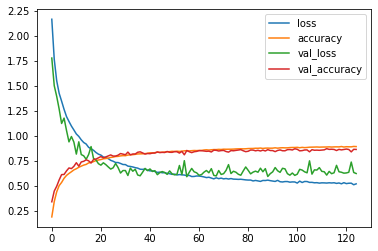

In [15]:
pd.DataFrame(history.history).plot()

### Evaluating model on the test set

In [16]:
scores = model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.6417 - accuracy: 0.8597


### Make predictions

In [17]:
pred = model.predict(X_test)

In [18]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
errors = y_pred - y_true != 0

### Print Classification Report
This gives us a breaksdown of scores per label. We can see from the report below that our model has learned classifiying automobiles, ships and truck with a 90% precision and recall, and around 75-90% on all the other categories

In [21]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1000
           1       0.94      0.95      0.94      1000
           2       0.88      0.76      0.81      1000
           3       0.78      0.69      0.73      1000
           4       0.87      0.81      0.84      1000
           5       0.82      0.77      0.80      1000
           6       0.78      0.96      0.86      1000
           7       0.84      0.93      0.88      1000
           8       0.93      0.92      0.93      1000
           9       0.89      0.92      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



### Check the predictions

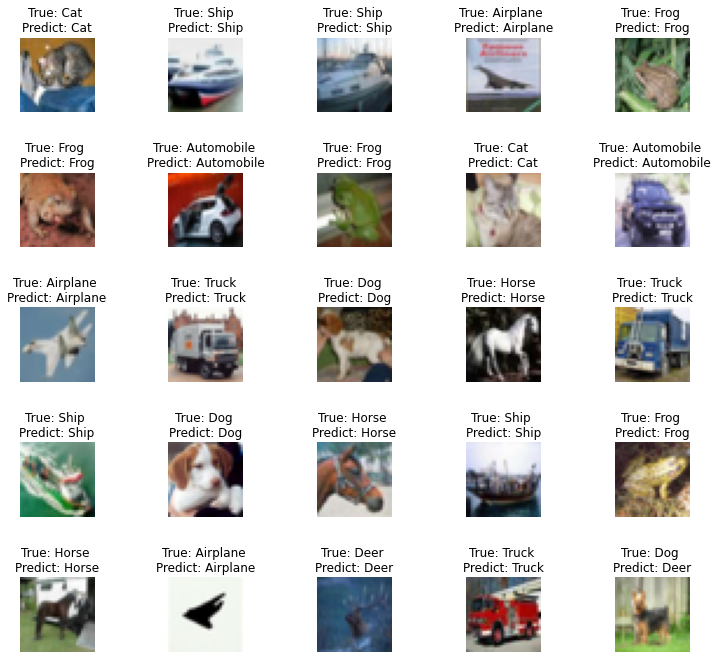

In [26]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(25):
    axes[i].imshow(X_test[i])
    axes[i].set_title('True: %s \nPredict: %s' % (labels[y_true[i]], labels[y_pred[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

### Check the wrong predictions

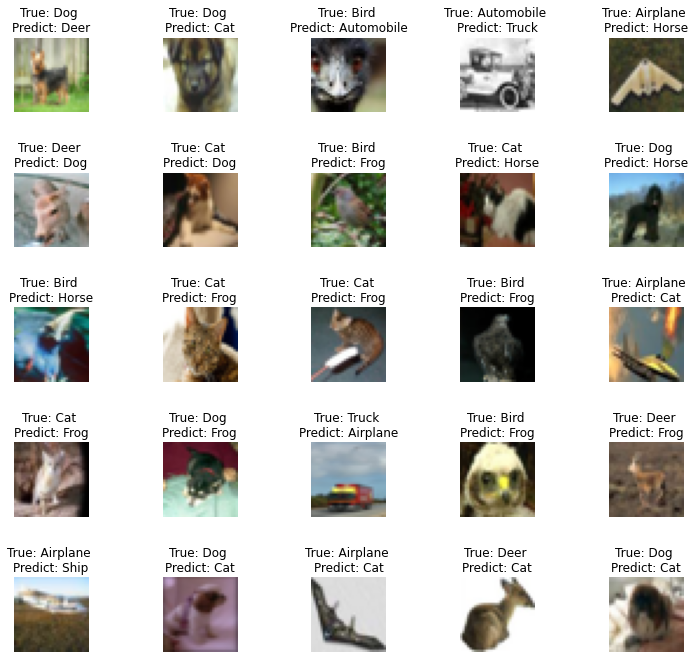

In [27]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

miss_pred = np.where(y_pred != y_true)[0]
for i in np.arange(25):
    axes[i].imshow(X_test[miss_pred[i]])
    axes[i].set_title('True: %s \nPredict: %s' % (labels[y_true[miss_pred[i]]], labels[y_pred[miss_pred[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

We can see from the pictures above that our model is perofrming really well, all the misclassified images can very easily be misclassified by a human as well. They are very similar to the mislcassfied prediction. 

### Saving the model
Always save the model and weights so that we can use this trained model and experiment with different parameters to recreate it.

In [28]:
model.save('cifar10_cnn.h5')